# ADTOF Exploratory Data Analysis

In [1]:
#!/bin/env python
# -*- coding: utf-8 -*-

import sys
import os

import aubio
import librosa

import pandas as pd
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

from pathlib import Path
from functools import reduce
from dataclasses import asdict

sys.path.append('..')
from tools import audio_tools, meta_tools, misc_tools


## Exploring Audio and Annotations

We'll start by exploring the dataset at a high level, loading in some audio and having a listen. Then we'll plot the annotations for this audio file, before delving into some more detailed EDA.

In [2]:
DATASET_PATH = Path(r'..\..\data\ADTOF-master\dataset')

### Exploring the Audio Data

First, lets load an audio file. We'll check its dimensions, and listen to some of its output.

In [3]:
source = audio_tools.in_out.init_audio(DATASET_PATH / 'audio/audio/Crystal Waters - 100% Pure Love.wav')
audio, sr = audio_tools.in_out.read_audio(source)
audio.shape

(8475136,)

The first 10 seconds of the audio file was silence, so we'll just listen to the next 10 seconds. The prescence of so much silence indicates that we'll have to construct a model that can deal with many frames of silence in a row.

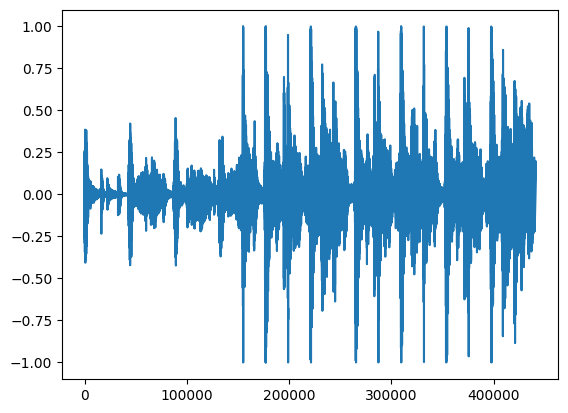

In [4]:
ipd.display(ipd.Audio(audio[441000:882000], rate=sr, normalize=False))
plt.plot(audio[441000:882000])
plt.show()

Okay, lets explore some aspects of the audio data.

#### Sample Rates

In [5]:
def get_srs(path):
    source = audio_tools.in_out.init_audio(str(path))
    sr = source.samplerate
    source.close()
    return sr

srs = {path: get_srs(path) for path in (DATASET_PATH / 'audio/audio').iterdir()}

srs_df = pd.DataFrame.from_dict(srs, orient='index')
srs_df.value_counts()

44100    1725
48000      49
Name: count, dtype: int64

With most tracks at 44.1kHz and just a handful at 48kHz, it seems advisible to resample our dataset down to 44.1kHz.

#### BPM

In [6]:
# This section will calculate BPMs on demand.
# Multiprocessing can't be used, so this may take 20 mins or more for ~1800 files.
# It is recommended to instead use scripts/get_bpms.py to write BPMs to a file 
# def get_tempo(path):
#     source = audio_tools.in_out.init_audio(path)
#     t = meta_tools.analysis.get_bpm(source)
#     return t
# bpms = [get_tempo(path) for path in (DATASET_PATH / 'audio/audio').iterdir()]i

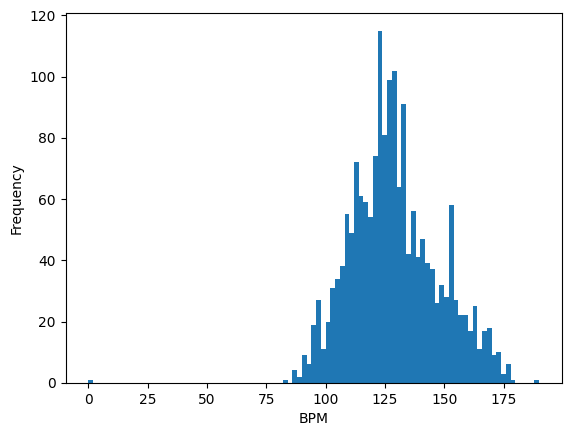

In [7]:
# Read BPMs previously written to a file using scripts/get_bpms.py
bpms_csv = pd.read_csv(DATASET_PATH / 'audio/bpms.csv', names=['path', 'bpm'])
# Round all BPMs to 0 decimal places
bpms_csv['bpm'] = bpms_csv['bpm'].round(0)
# Plot a histogram for our BPMs with a bin count equal to the number of unique BPMs
num_bpms = len(bpms_csv['bpm'].unique())
ax = bpms_csv['bpm'].plot.hist(bins=num_bpms)
ax.set_xlabel('BPM')
plt.show()

A pretty normal-looking distribution of BPMs, centred around 125 BPM. There are a couple of outliers: we appear to have quite a few songs around 155 BPM, and at least one song with a BPM of 0 (failed to be estimated by the BPM estimator.)

### Exploring the Annotations

Next, lets load in the annotations for the previously loaded file.

In [8]:
annotations = meta_tools.in_out.read_annotations_ADTOF(DATASET_PATH / 'annotations/aligned_drum/Crystal Waters - 100% Pure Love.txt')
len(annotations)

1006

In [9]:
def construct_annotation_matrix(annotations: list, audio: np.array, sr: int):
    """
    Construct a binary matrix to represent the presence of annotations
     at each sample in a file.

    :param annotations: (list) Placeholder
    :param audio: (np.array) Placeholder
    :param sr: (int) The sampling rate, in Hz.

    :return: Placeholder
    """
    
    # Get each unique instrument in our annotation
    instruments = np.unique([annotation.instrument for annotation in annotations])
    num_instruments = len(instruments)
    index_instrument_mapping = dict(enumerate(instruments))

    # Construct an empty array, the same size as our input audio
    annotation_matrix = np.zeros_like(audio, dtype=bool)
    # Stack this array `num_instruments` times, over the first axis
    # We now have a matrix, in which each instrument has a single row of annotations
    annotation_matrix = np.stack([annotation_matrix] * num_instruments, axis=0)
    # We will populate each cell (or sample) in each row with `True` values
    # if an Annotation is reporting an onset of that row's instrument at that sample
    # and otherwise leave these values `False`.

    # For each unique instrument...
    for instrument_index, instrument in enumerate(instruments):
        # ... get all of the Annotations containing this instrument
        instrument_annotations = (annotation for annotation in annotations if annotation.instrument == instrument)
        # For each Annotation containing our instrument...
        for annotation in instrument_annotations:
            # ... get the Annotation's onset in samples and set this sample `True`
            onset_samples = misc_tools.misc.seconds_to_samples(annotation.onset, sr)
            annotation_matrix[instrument_index][onset_samples] = True
    return annotation_matrix, index_instrument_mapping

annotation_matrix, index_instrument_mapping = construct_annotation_matrix(annotations, audio, sr)

Now that we have loaded the annotations and put them into a usable format, we can take a look at the audio and annotations together.

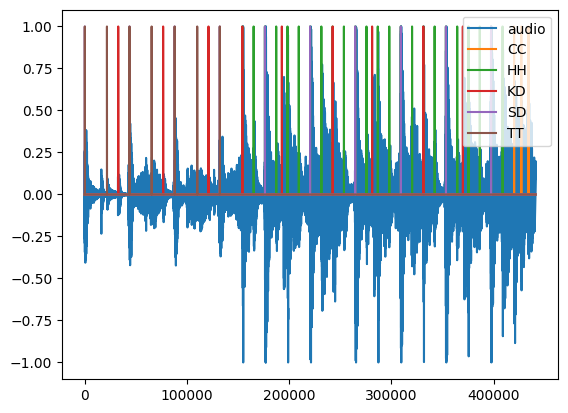

In [10]:
plt.plot(audio[441000:882000], label='audio')
for instrument_index in range(annotation_matrix.shape[0]):
    plt.plot(annotation_matrix[instrument_index][441000:882000], label=index_instrument_mapping[instrument_index])
plt.legend(loc='upper right')
plt.show()

From the above plot (and some intuition about how drums are played), it looks like we'll be dealing with a farily heavily imbalanced set of instrument classes.

To verify this intuition, let's start exploring the annotations in a broader context. We'll load in all of the annotations from the dataset, and plot the instrument class counts.

In [11]:
# Read all annotations from the dataset
all_annotations = [meta_tools.in_out.read_annotations_ADTOF(path) for path in (DATASET_PATH / 'annotations/aligned_drum/').iterdir()]
# Prune empty files
all_annotations = [annotations for annotations in all_annotations if annotations]
# Convert all annotations to dictionary form
all_annotations_dicts = [[asdict(annotation) for annotation in annotations] for annotations in all_annotations]
# Create a new dataframe for each set of annotations
annotations_dfs = [pd.DataFrame.from_records(annotations) for annotations in all_annotations_dicts]
# Print number of annotated tracks
len(annotations_dfs)

1586

In [12]:
# Check for empty dataframes

for index, annotation_df in enumerate(annotations_dfs):
    if 'instrument' not in annotation_df:
        print(f'Dataframe {index}')
        print(f'annotation_df')

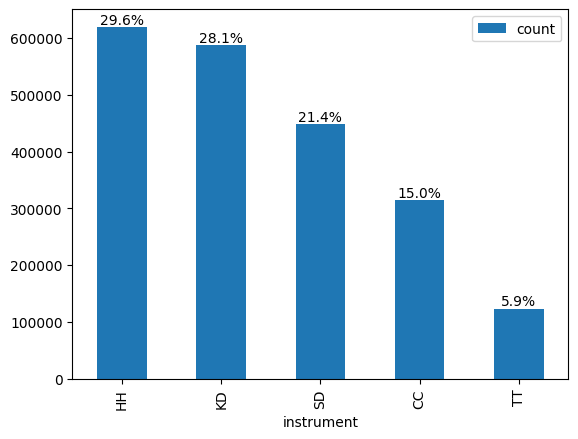

In [13]:
# Get the number of times each instrument appears within each set of annotations
instruments_counts = [annotations['instrument'].value_counts().to_frame() for annotations in annotations_dfs]
# Sum the number of times each instrument appears within each set of annotations, getting the total number of times
# each instrument appears across the entire dataset
instruments_counts = reduce(lambda x, y: x.add(y, fill_value=0), instruments_counts)
# Sort these counts in descending order
instruments_counts = instruments_counts.sort_values('count', ascending=False)

# Calculate the number of times each instrument appears across the entire dataset as a percentage
# of the total number of individual annotations
total = instruments_counts.sum()
labels = instruments_counts / total * 100
labels = labels["count"].round(1).astype('str') + '%'

# Plot the above calculations
ax = instruments_counts.plot.bar()
for container in ax.containers:
    ax.bar_label(container, labels=labels)

It's true---we will be dealing with quite an imbalanced set of classes. We'll have to account for this at training time.

## Exploring Metadata